#### <b>Download the Original Datasets</b>

* <b>CelebA-HQ Dataset</b>: A dataset consisting of 30,000 "human face" images.
    * This dataset has approximately 3GB of data in size and is one of the most widely used face datasets worldwide.
* <b>CelebA-HQ Identity Dataset</b>: A dataset that provides information about <b>who the individuals (subjects) are</b> for each facial image file.
* <b>CelebA-HQ Attribute Dataset</b>: A dataset that provides attribute information for each facial image file.
    * This attribute information includes <b>gender</b>, <b>smiling</b>, and <b>age</b>, which we will be used for a multi-label task.

In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb37jNPPA7hHl0fmktYqcV8B-qmPLx-ZKYQ1eFk4UPBV_A?download=1 -O CelebAMask-HQ.zip
!wget https://postechackr-my.sharepoint.com/:t:/g/personal/dongbinna_postech_ac_kr/EVRoUY8_txRFv56-KWvZrksBDWbD6adkjBxwwRN7qAC6bg?download=1 -O CelebA-HQ-identity.txt
!wget https://postechackr-my.sharepoint.com/:t:/g/personal/dongbinna_postech_ac_kr/EVrdIrPOkR1OlEWBVK8lE3AB9bFh741GnKBkNgPa8trNuA?download=1 -O CelebA-HQ-attribute.txt

--2023-11-03 17:45:08--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb37jNPPA7hHl0fmktYqcV8B-qmPLx-ZKYQ1eFk4UPBV_A?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/datasets/CelebAMask-HQ/CelebAMask-HQ.zip?ga=1 [following]
--2023-11-03 17:45:09--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/datasets/CelebAMask-HQ/CelebAMask-HQ.zip?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 3153930546 (2.9G) [application/x-zip-compressed]
Saving to: ‘CelebAMask-HQ.zip’

CelebAMask-HQ.zip   100%[===================>]   2.94G  68.8MB/s    in

In [ ]:
%%capture
!rm -rf ./CelebAMask-HQ
!unzip CelebAMask-HQ.zip

#### <b>Load Libraries</b>

* Load various useful python libraries for the experiments.

In [ ]:
import os
import time
import random
import glob
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import linear_model, model_selection

In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def compute_losses(net, loader):
    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, labels in loader:
        targets = labels
        inputs, targets = inputs.cuda(), targets.cuda()

        logits = net(inputs)

        losses = criterion(logits, targets).cpu().detach().numpy()
        #losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )


def cal_mia(model):

    set_seed(42)

    forget_losses = compute_losses(model, forget_dataloader_test)
    unseen_losses = compute_losses(model, unseen_dataloader)

    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(unseen_losses)]

    samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)
    forgetting_score = abs(0.5 - mia_scores.mean())

    return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}


@torch.no_grad()
def evaluation(model, data_loader):
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in data_loader:
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = model(inputs)  # Use the passed model argument here
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Use data_loader's dataset length for normalization
        epoch_loss = running_loss / len(data_loader.dataset)
        epoch_loss = round(epoch_loss, 3)
        epoch_acc = running_corrects.item() / len(data_loader.dataset)

        return {'Loss': epoch_loss, 'Acc': epoch_acc}

#### <b>Load Identity Mapping</b>
* Check which person each file name is associated with.
* There are a total of 6,217 individuals (subjects) among the 30,000 files.

In [ ]:
path = "./"

In [ ]:
identities = {}

# (Image File Name, Subject Identity Information)
with open(path + 'CelebA-HQ-identity.txt') as f:
    lines = f.readlines()
    for line in lines:
        file_name, identity = line.strip().split()
        identities[file_name] = identity

print(f'There are {len(set(identities.values()))} identities.')
print(f'There are {len(identities.keys())} images.')

There are 6217 identities.
There are 30000 images.


#### <b>Choose Single Label to Use</b>
* "male": 21,
* "smiling": 32,
* "young": 40

In [ ]:
label_map = {}

label_num = 40  # "male": 21, "smiling": 32, "young": 40

with open('./CelebA-HQ-attribute.txt') as f:
    lines = f.readlines()
    for line in lines[2:]:
        splited = line.strip().split()
        file_name, label = splited[0], splited[label_num]
        label_map[file_name] = label

print(f'There are {len(set(label_map.values()))} classes.')
print(f'There are {len(label_map.keys())} images.')

There are 2 classes.
There are 30000 images.


#### <b>Split the Dataset</b>
* <b>Training dataset  $\mathcal{D}_{train}$</b>: 25,933 images.
* <b>Test dataset $\mathcal{D}_{test}$</b>: 2,065 images.
* <b>Unseen dataset $\mathcal{D}_{unseen}$</b>: 2,002 images.

In [ ]:
source_root = path + 'CelebAMask-HQ/CelebA-HQ-img/'

train_index = 190
retain_index = 1250
unseen_index = 4855

In [ ]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity >= train_index and identity < unseen_index:
                label = int(label_map[file_name])
                if label == -1: label = 0
                self.labels.append((label, identity))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label[0])

        return image, label

In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []
        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < train_index:
                label = int(label_map[file_name])
                if label == -1: label = 0
                self.labels.append((label, identity))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label[0])

        return image, label

In [ ]:
class ForgetDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity >= train_index and identity < retain_index:
                label = int(label_map[file_name])
                if label == -1: label = 0
                self.labels.append((label, identity))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label[0])

        return image, label

In [ ]:
class RetainDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < unseen_index and identity >= retain_index:
                label = int(label_map[file_name])
                if label == -1: label = 0
                self.labels.append((label, identity))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label[0])

        return image, label

In [ ]:
class UnseenDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []
        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < unseen_index:
                continue
            label = int(label_map[file_name])
            if label == -1: label = 0
            self.labels.append((label, identity))
            self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label[0])

        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

unseen_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

train_set = TrainDataset(transform=train_transform)
test_set = TestDataset(transform=test_transform)
forget_set_train = ForgetDataset(transform=train_transform)
forget_set_test = ForgetDataset(transform=test_transform)
retain_set_train = RetainDataset(transform=train_transform)
retain_set_test = RetainDataset(transform=test_transform)
unseen_set = UnseenDataset(transform=unseen_transform)

In [ ]:
print('Train dataset size:', len(train_set))
print('Test dataset size:', len(test_set))
print('Forget dataset size:', len(forget_set_train))
print('Retain dataset size:', len(retain_set_train))
print('Unseen dataset size:', len(unseen_set))

Train dataset size: 25933
Test dataset size: 2065
Forget dataset size: 10183
Retain dataset size: 15750
Unseen dataset size: 2002



* In the NeurIPS Competition setting, when performing machine unlearning, training is done with 'retain' and 'forget', so augmentation can be applied. However, it should never be applied during evaluation.

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
forget_dataloader_train = torch.utils.data.DataLoader(forget_set_train, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
forget_dataloader_test = torch.utils.data.DataLoader(forget_set_test, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
retain_dataloader_train = torch.utils.data.DataLoader(retain_set_train, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
retain_dataloader_test = torch.utils.data.DataLoader(retain_set_test, batch_size=64, shuffle=False, num_workers=2,pin_memory=True)
unseen_dataloader = torch.utils.data.DataLoader(unseen_set, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
train_image_paths = TrainDataset().image_paths
test_image_paths = TestDataset().image_paths
forget_image_paths = ForgetDataset().image_paths
retain_image_paths = RetainDataset().image_paths
unseen_image_paths = UnseenDataset().image_paths

train_test_overlap = len(set(train_image_paths) & set(test_image_paths))
train_forget_overlap = len(set(train_image_paths) & set(forget_image_paths))
train_retain_overlap = len(set(train_image_paths) & set(retain_image_paths))
train_unseen_overlap = len(set(train_image_paths) & set(unseen_image_paths))
test_forget_overlap = len(set(test_image_paths) & set(forget_image_paths))
test_retain_overlap = len(set(test_image_paths) & set(retain_image_paths))
test_unseen_overlap = len(set(test_image_paths) & set(unseen_image_paths))
forget_retain_overlap = len(set(forget_image_paths) & set(retain_image_paths))
forget_unseen_overlap = len(set(forget_image_paths) & set(unseen_image_paths))
retain_unseen_overlap = len(set(retain_image_paths) & set(unseen_image_paths))

overlap_dict = {
    'train_test': train_test_overlap,
    'train_forget': train_forget_overlap,
    'train_retain': train_retain_overlap,
    'train_unseen': train_unseen_overlap,
    'test_forget': test_forget_overlap,
    'test_retain': test_retain_overlap,
    'test_unseen': test_unseen_overlap,
    'forget_retain': forget_retain_overlap,
    'forget_unseen': forget_unseen_overlap,
    'retain_unseen': retain_unseen_overlap
}
overlap_dict

{'train_test': 0,
 'train_forget': 10183,
 'train_retain': 15750,
 'train_unseen': 0,
 'test_forget': 0,
 'test_retain': 0,
 'test_unseen': 0,
 'forget_retain': 0,
 'forget_unseen': 0,
 'retain_unseen': 0}

#### <b>Imgae Visualization</b>

In [ ]:
if label_num == 21:
    label_convert = {0: "F", 1: "M"}
elif label_num == 32:
    label_convert = {0: "unsmiling", 1: "smiling"}
if label_num == 40:
    label_convert = {0: "old", 1: "young"}

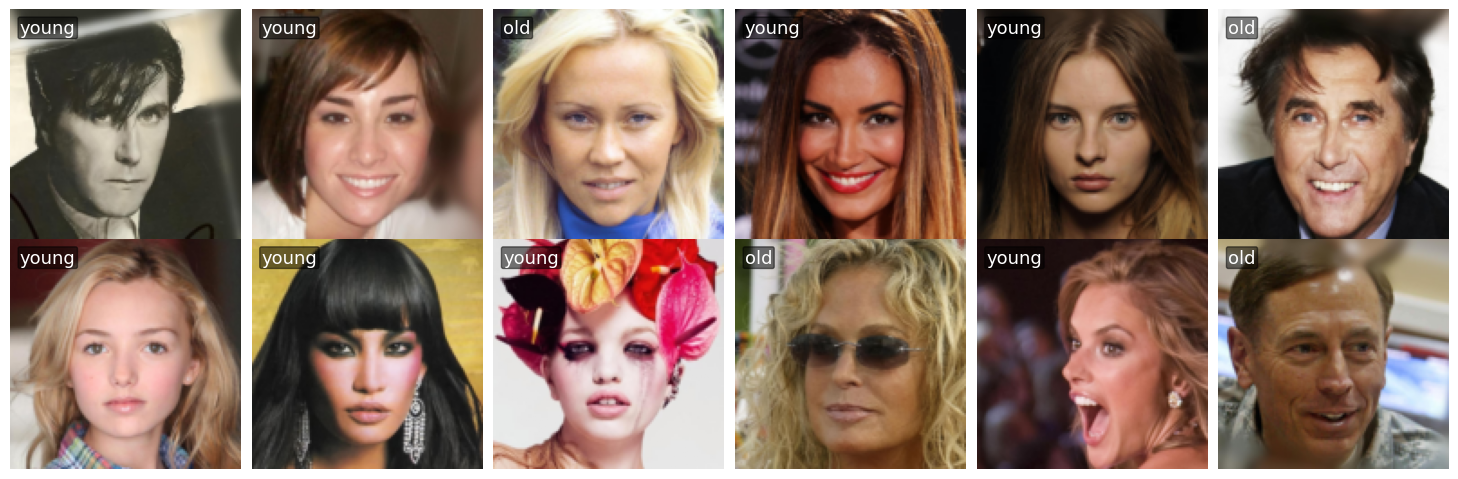

In [ ]:
def show_images(images, labels, nrow=6, save_path=None):
    n_images = len(images)
    nrows = n_images // nrow + (n_images % nrow > 0)

    fig, axs = plt.subplots(nrows, nrow, figsize=(14.5, 2.3 * nrows), frameon=False)
    axs = axs.flatten() if n_images > 1 else [axs]

    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axs[idx]
        img_np = img.numpy().transpose((1, 2, 0))
        ax.imshow(img_np)
        ax.axis('off')

        ax.text(5, 5, label, color='white', fontsize=13,  ha='left', va='top',
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.1'))

    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

iterator = iter(test_dataloader)
imgs, labels = next(iterator)

label_strs = [label_convert[label.item()] for label in labels[0:12]]

show_images(imgs[0:12], label_strs, nrow=6)

#### <b>(Option) Load the Pre-trained Original Model</b>

* We can easily download the pre-trained original model, rather than training the original model from scratch.
* <b>Download Link</b>:
    * gender: https://drive.google.com/file/d/1BzvUyFBHWQpTseBY8N6GaT1RrlhiTgZp/view?usp=drive_link
    * young: https://drive.google.com/file/d/15BmYjzvXs_57BcvN6haAgWJ2fYdSZfjW/view?usp=drive_link
    * smiling: https://drive.google.com/file/d/1lr0ozk9AUzm9ybqMbT7ixGnRdDrOUqhe/view?usp=drive_link

In [ ]:
# male vs female
# !gdown https://drive.google.com/uc?id=1BzvUyFBHWQpTseBY8N6GaT1RrlhiTgZp -O pre_trained_checkpoint.pth

Downloading...
From: https://drive.google.com/uc?id=1BzvUyFBHWQpTseBY8N6GaT1RrlhiTgZp
To: /content/pre_trained_checkpoint.pth
100% 44.8M/44.8M [00:00<00:00, 186MB/s]


In [ ]:
# young vs old
!gdown https://drive.google.com/uc?id=15BmYjzvXs_57BcvN6haAgWJ2fYdSZfjW -O pre_trained_checkpoint.pth

Downloading...
From: https://drive.google.com/uc?id=15BmYjzvXs_57BcvN6haAgWJ2fYdSZfjW
To: /content/pre_trained_checkpoint.pth
100% 44.8M/44.8M [00:02<00:00, 19.4MB/s]


In [ ]:
# smiling vs unsmiling
# !gdown https://drive.google.com/uc?id=1lr0ozk9AUzm9ybqMbT7ixGnRdDrOUqhe -O pre_trained_checkpoint.pth

Downloading...
From: https://drive.google.com/uc?id=1lr0ozk9AUzm9ybqMbT7ixGnRdDrOUqhe
To: /content/pre_trained_checkpoint.pth
100% 44.8M/44.8M [00:00<00:00, 270MB/s]


<b>Performance Test</b>

In [ ]:
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.cuda()
# model_path = f'last_checkpoint_epoch_{num_original_epochs}_gender.pth' # If you trian the original model from scratch.
model_path = f'pre_trained_checkpoint.pth'  # downloaded model
model.load_state_dict(torch.load(model_path))
criterion = nn.CrossEntropyLoss()

test_acc = evaluation(model, test_dataloader)
unseen_acc = evaluation(model, unseen_dataloader)
mia = cal_mia(model.cuda())
print()
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')


Test Acc: {'Loss': 0.233, 'Acc': 0.908958837772397}
Unseen Acc: {'Loss': 0.418, 'Acc': 0.8146853146853147}
MIA: {'MIA': 0.542643391521197, 'Forgeting Score': 0.042643391521197005}
Final Score: 0.9118360273650015


#### <b>Machine Unlearning Experiments</b>

#### <b>Scrub</b>
* A student model learns from a teacher model to retain or forget data
* It minimizes divergence from the teacher on retain data and maximizes divergence on forget data.

In [ ]:
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}_gender.pth' # If you trian the original model from scratch.
original_save_path = f'pre_trained_checkpoint.pth'  # downloaded model
original_model = models.resnet18(pretrained=True)
num_features = original_model.fc.in_features
original_model.fc = nn.Linear(num_features, 2)
original_model = original_model.cuda()
original_model.load_state_dict(torch.load(original_save_path))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.4MB/s]


<All keys matched successfully>

In [ ]:
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}_gender.pth' # If you trian the original model from scratch.
original_save_path = f'pre_trained_checkpoint.pth'  # downloaded model
scrub_model = models.resnet18(pretrained=True)
num_features = scrub_model.fc.in_features
scrub_model.fc = nn.Linear(num_features, 2)
scrub_model = scrub_model.cuda()
scrub_model.load_state_dict(torch.load(original_save_path))
criterion = nn.CrossEntropyLoss()

In [ ]:
class DistillKL(nn.Module):
    def __init__(self, T):
        super(DistillKL, self).__init__()
        self.T = T

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.T, dim=1)
        loss = F.kl_div(p_s, p_t, size_average=False) * (self.T**2) / y_s.shape[0]
        return loss

In [ ]:
class SCRUBTraining:
    def __init__(self, teacher, student, retain_dataloader, forget_dataloader):
        self.teacher = teacher
        self.student = student
        self.retain_dataloader = retain_dataloader
        self.forget_dataloader = forget_dataloader

        self.criterion_cls = nn.CrossEntropyLoss()
        self.criterion_div = DistillKL(4.0)
        self.criterion_kd = DistillKL(4.0)

        self.optimizer = optim.SGD(student.parameters(), lr=0.0001)

    def train_epoch(self):
        self.student.train()
        self.teacher.eval()

        # Function to compute accuracy.
        def compute_accuracy(outputs, labels):
            _, predicted = outputs.max(1)
            total = labels.size(0)
            correct = predicted.eq(labels).sum().item()
            return 100 * correct / total

        total_loss_retain, total_accuracy_retain = 0, 0
        total_loss_forget, total_accuracy_forget = 0, 0

        # Training with retain data.
        for inputs_retain, labels_retain in self.retain_dataloader:
            inputs_retain, labels_retain = inputs_retain.cuda(), labels_retain.cuda()

            # Forward pass: Student
            outputs_retain_student = self.student(inputs_retain)

            # Forward pass: Teacher
            with torch.no_grad():
                outputs_retain_teacher = self.teacher(inputs_retain)

            # Loss computation
            loss_cls = self.criterion_cls(outputs_retain_student, labels_retain)
            loss_div_retain = self.criterion_div(outputs_retain_student, outputs_retain_teacher)

            loss = loss_cls + loss_div_retain

            # Update total loss and accuracy for retain data.
            total_loss_retain += loss.item()
            total_accuracy_retain += compute_accuracy(outputs_retain_student, labels_retain)

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        # Training with forget data.
        for inputs_forget, labels_forget in self.forget_dataloader:
            inputs_forget, labels_forget = inputs_forget.cuda(), labels_forget.cuda()

            # Forward pass: Student
            outputs_forget_student = self.student(inputs_forget)

            # Forward pass: Teacher
            with torch.no_grad():
                outputs_forget_teacher = self.teacher(inputs_forget)

            # We want to maximize the divergence for the forget data.
            loss_div_forget = -self.criterion_div(outputs_forget_student, outputs_forget_teacher)

            # Update total loss and accuracy for forget data.
            total_loss_forget += loss_div_forget.item()
            total_accuracy_forget += compute_accuracy(outputs_forget_student, labels_forget)

            # Backward pass
            self.optimizer.zero_grad()
            loss_div_forget.backward()
            self.optimizer.step()

        # Print average loss and accuracy for the entire epoch
        avg_loss_retain = total_loss_retain / len(self.retain_dataloader)
        avg_accuracy_retain = total_accuracy_retain / len(self.retain_dataloader)

        avg_loss_forget = total_loss_forget / len(self.forget_dataloader)
        avg_accuracy_forget = total_accuracy_forget / len(self.forget_dataloader)

        print(f'Epoch Retain: Avg Loss: {avg_loss_retain:.4f}, Avg Accuracy: {avg_accuracy_retain:.2f}%')
        print(f'Epoch Forget: Avg Loss: {avg_loss_forget:.4f}, Avg Accuracy: {avg_accuracy_forget:.2f}%')

In [ ]:
set_seed(42)

teacher = original_model
student = scrub_model

# Initialize and train
scrub_trainer = SCRUBTraining(teacher, student, retain_dataloader_train, forget_dataloader_train)

num_epochs = 1
for epoch in range(num_epochs):
    scrub_trainer.train_epoch()
    print(f"Epoch {epoch+1} completed.")

Epoch Retain: Avg Loss: 4.2722, Avg Accuracy: 34.16%
Epoch Forget: Avg Loss: -35.8068, Avg Accuracy: 71.39%
Epoch 1 completed.


In [ ]:
# Performance
test_acc = evaluation(scrub_model, test_dataloader)
unseen_acc = evaluation(scrub_model, unseen_dataloader)
mia = cal_mia(scrub_model.cuda())
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

Test Acc: {'Loss': 5.157, 'Acc': 0.23728813559322035}
Unseen Acc: {'Loss': 2.853, 'Acc': 0.5559440559440559}
MIA: {'MIA': 0.5992518703241896, 'Forgeting Score': 0.09925187032418958}
Final Score: 0.5193921974724206
